In [45]:
import os
import random
import time
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset,ConcatDataset, DataLoader, Subset, random_split
import torchvision.transforms as T
from torchvision import datasets, models, transforms,utils
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, f1_score
from tempfile import TemporaryDirectory
from pathlib import Path

# Enables the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
# Effective when input sizes for the network do not vary.
cudnn.benchmark = True

plt.ion()   # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [6]:
# connect to the google drive disk
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# define path to the datasets folder and datasets names
data_path = '/content/drive/MyDrive/neoversity/deep-learning/'
splits = ['train', 'test']

In [8]:
# define classes based on folder names
classes={
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

In [9]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [10]:
# create function for file names grouping in dictionary
def add_imgs_to_dict(path_dir, number_of_images=100):
  files_by_group_name = defaultdict(list)
  if path_dir.is_dir():
    for child_dir in path_dir.iterdir():
        for idx, file in enumerate(child_dir.iterdir()):
          if idx==number_of_images:
            break
          if file.is_file and file.name.endswith('.jpg'):
            if child_dir.name in classes.keys():
              # files_by_group_name[child_dir.name].append(file.name)
              files_by_group_name[classes[child_dir.name]].append(os.path.join(path_dir, f'{child_dir.name}/{file.name}'))

  return files_by_group_name

# create function to display images
def display_images(dictionary):
  for key, value in dictionary.items():
    print(f'"{get_key(classes, key)}" folder contains {len(value)} images (class {key})')
    imgs_path=random.sample(value, 4)

    # read the image using the opencv library
    imgs = [cv2.imread(p) for p in imgs_path]
    # matplotlib expects img in RGB format but OpenCV provides it in BGR
    # transform the BGR image into RGB
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

    # create a figure for display
    fig = plt.figure(figsize=(7, 2))
    grid = ImageGrid(
      fig, 111,
      nrows_ncols=(1, 4)
    )
    # display the image
    for ax, img in zip(grid, imgs):
      ax.imshow(img)

    fig.suptitle(f'Class {key}')
    plt.show()



In [11]:
# define path to train and test folders
train_path=Path(f'{data_path}seg_train')
test_path=Path(f'{data_path}seg_test')

# obtain dictionaries with train and test file names defined size
train_files_dict=add_imgs_to_dict(train_path,500)
test_files_dict=add_imgs_to_dict(test_path,200)

"buildings" folder contains 500 images (class 0)


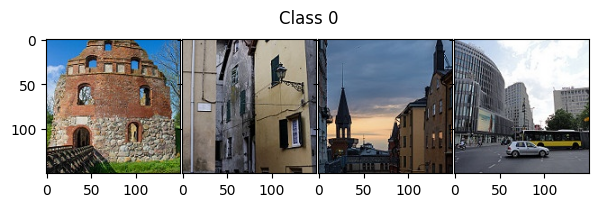

"street" folder contains 500 images (class 5)


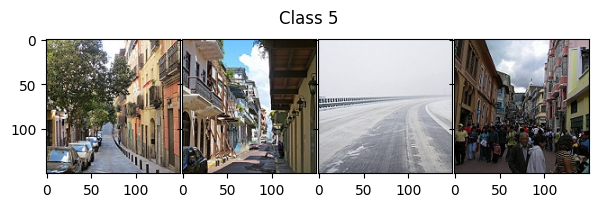

"mountain" folder contains 500 images (class 3)


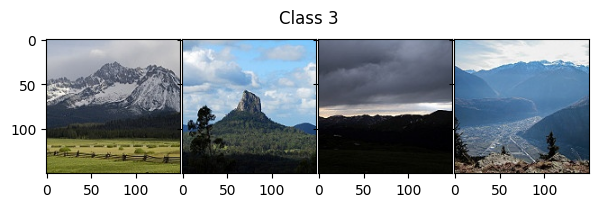

"sea" folder contains 500 images (class 4)


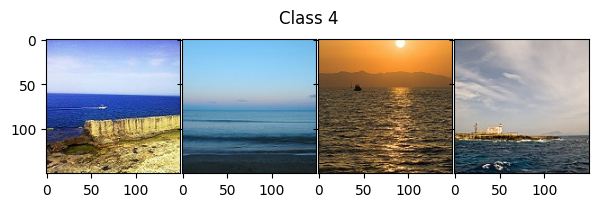

"glacier" folder contains 500 images (class 2)


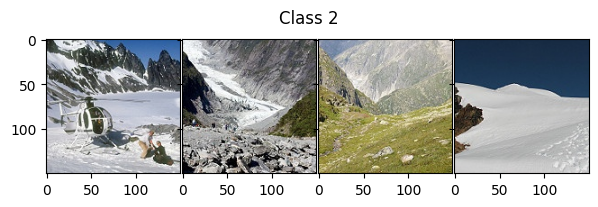

"forest" folder contains 500 images (class 1)


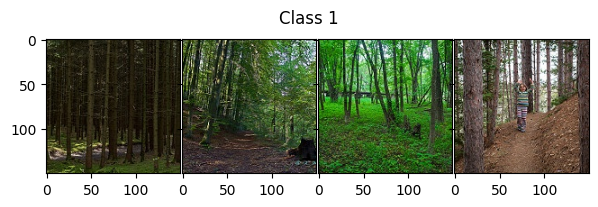

In [12]:
# display 4 images of each class
display_images( train_files_dict)

In [13]:
# create custom image Dataset
class ImgDataset(Dataset):
    def __init__(self, dictionary, transform):
        self.labels=list()
        self.filenames=list()
        # save file names and labels
        for key, value in dictionary.items():
          self.labels= self.labels+[key for _ in  range(len(value))]
          self.filenames= self.filenames+value

        self.transform = transform
        print('self.labels', len(self.labels))
        print('self.filenames', len(self.filenames))

    def __len__(self):
        # returns the size of the dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        # open the image, apply transformations and
        # return an image with a class label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [37]:
# define transformation
train_transformer = T.Compose([
    T.Resize((64,64)),              # resizing the image to 64x64
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

eval_transformer = T.Compose([
    T.Resize((64,64)),
    T.ToTensor()])

In [38]:
# get ImgDataset objects
train_dataset = ImgDataset(train_files_dict, train_transformer)
test_dataset = ImgDataset(test_files_dict, eval_transformer)

self.labels 3000
self.filenames 3000
self.labels 1200
self.filenames 1200


In [39]:
# Split dataset (70% training, 30% validation)
train_size = int(0.7 * len(train_dataset))
val_size = int(0.3 * len(train_dataset))

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(len(train_dataset))
print(len(val_dataset))

2100
900


In [40]:
# create basic convolutional neural network model class
class BaselineModel(nn.Module):

  def __init__(self, ):
    super().__init__()
    self.num_channels = 32

    # convolution base
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

    # classification layers
    self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

    # activation function
    self.af = nn.Softmax()

  def forward(self, s):
    #                         -> batch_size x 3 x 64 x 64
    s = self.conv1(s)                  # batch_size x num_channels x 64 x 64
    s = F.relu(F.max_pool2d(s, 2))           # batch_size x num_channels x 32 x 32
    s = self.conv2(s)                  # batch_size x num_channels*2 x 32 x 32
    s = F.relu(F.max_pool2d(s, 2))           # batch_size x num_channels*2 x 16 x 16
    s = self.conv3(s)                  # batch_size x num_channels*4 x 16 x 16
    s = F.relu(F.max_pool2d(s, 2))           # batch_size x num_channels*4 x 8 x 8

    # flatten the output for each image
    s = s.view(-1, 8*8*self.num_channels*4)       # batch_size x 8*8*num_channels*4

    # apply 2 fully connected layers with dropout
    s = F.relu(self.fc1(s))               # batch_size x self.num_channels*4
    s = self.fc2(s)                   # batch_size x 6
    # s = self.af(s)

    return F.log_softmax(s, dim=1)

In [41]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else None

torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)

# create train, validation and test DataLoaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=16,
                              shuffle=True,
                              num_workers=4)

val_dataloader = DataLoader(val_dataset,
                              batch_size=16,
                              shuffle=True,
                              num_workers=4)

test_dataloader = DataLoader(test_dataset,
                             batch_size=16,
                             shuffle=True,
                             num_workers=4)

In [48]:
# define function for a full cycle of a model training and evaluation
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs):
  # define lists to store train and test losses and accuracy
  train_losses = []
  train_accs = []

  test_losses = []
  test_accs = []

  # define full training and validation cycle
  for epoch in tqdm(range(num_epochs)):

    # Train step

    model.train()

    train_epoch_loss = []
    train_epoch_acc = []
    train_epoch_f1_score = []

    for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
      if cuda:
          # non_blocking=True enables asynchronous data transfer to reduce runtime
          train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

      # compute model output and loss
      output_batch = model(train_batch)

      loss = criterion(output_batch, labels_batch)

      # clear previous gradients, compute gradients of all variables wrt loss
      optimizer.zero_grad()
      loss.backward()

      # performs updates using calculated gradients
      optimizer.step()

      batch_loss = loss.cpu().detach().numpy()
      batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                        labels_batch.cpu().detach().numpy())
      batch_f1_score = f1_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                        labels_batch.cpu().detach().numpy(), average='weighted')

      train_epoch_loss.append(batch_loss)
      train_epoch_acc.append(batch_acc)
      train_epoch_f1_score.append(batch_f1_score)



    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}, F1-score: {np.mean(train_epoch_f1_score)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))

    # Eval step

    model.eval()

    test_epoch_loss = []
    test_epoch_acc = []
    test_epoch_f1_score = []

    with torch.no_grad():

      for i, (test_batch, labels_batch) in enumerate(test_dataloader):
        if cuda:
          test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

        # compute model output and loss
        output_batch = model(test_batch)

        loss = criterion(output_batch, labels_batch)

        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                          labels_batch.cpu().detach().numpy())
        batch_f1_score = f1_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                        labels_batch.cpu().detach().numpy(), average='weighted')

        test_epoch_loss.append(batch_loss)
        test_epoch_acc.append(batch_acc)
        test_epoch_f1_score.append(batch_f1_score)

    print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}, , F1-score: {np.mean(test_epoch_f1_score)}')
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))
  return   train_losses,test_losses, train_accs, test_accs


We will estimate our model performance using balanced accuracy score and F1 score metrics from sklearn package. F1 score involves evaluating the precision and recall of your model. The F1 score is the harmonic mean of precision and recall and is particularly useful when we want to account for both false positives and false negatives.Balanced accuracy is effective in multiclass classification problems where class imbalance can occur across multiple categories.

In [43]:
# define function for train and test losses visualisation
def plot_loss_graph(train_losses,test_losses):
  plt.figure(figsize=(4, 3))
  plt.plot(train_losses, label='Train')
  plt.plot(test_losses, label='Validation')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy Loss')
  plt.title('Training vs Validation Loss')
  plt.show()

# define function for train and test balanced accuracy score visualisation
def plot_accuracy_graph(train_acc,test_acc):
  plt.figure(figsize=(4, 3))
  plt.plot(train_acc, label='Train')
  plt.plot(test_acc, label='Validation')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Balanced Accuracy Score')
  plt.title('Training vs Validation Metric - Accuracy')
  plt.show()

****************************************
First train model on train and validation data
****************************************

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/10], Loss: 1.3752, Acc: 0.450290963946267, F1-score: 0.48691115460621515
Test epoch [1/10], Loss: 1.2016, Acc: 0.527199596212754, , F1-score: 0.5385468332836754


0it [00:00, ?it/s]

Train epoch [2/10], Loss: 1.0590, Acc: 0.6126429473304474, F1-score: 0.6041155393428123
Test epoch [2/10], Loss: 1.2343, Acc: 0.5548966165413534, , F1-score: 0.5322141065562118


0it [00:00, ?it/s]

Train epoch [3/10], Loss: 0.9484, Acc: 0.6377310806477473, F1-score: 0.6397716025556933
Test epoch [3/10], Loss: 0.9088, Acc: 0.6845210247841828, , F1-score: 0.6676092304381779


0it [00:00, ?it/s]

Train epoch [4/10], Loss: 0.8500, Acc: 0.7000041085457751, F1-score: 0.691780564670772
Test epoch [4/10], Loss: 0.8285, Acc: 0.707962962962963, , F1-score: 0.7098007438467966


0it [00:00, ?it/s]

Train epoch [5/10], Loss: 0.7612, Acc: 0.7263967051467051, F1-score: 0.7148861496371524
Test epoch [5/10], Loss: 0.8058, Acc: 0.7020820569943377, , F1-score: 0.7050215835577678


0it [00:00, ?it/s]

Train epoch [6/10], Loss: 0.7032, Acc: 0.7499494949494949, F1-score: 0.7429858230994595
Test epoch [6/10], Loss: 0.7497, Acc: 0.7249006776199759, , F1-score: 0.7372152067488755


0it [00:00, ?it/s]

Train epoch [7/10], Loss: 0.6529, Acc: 0.7621732202982202, F1-score: 0.7510367368321914
Test epoch [7/10], Loss: 0.7434, Acc: 0.7365079365079363, , F1-score: 0.730562006219901


0it [00:00, ?it/s]

Train epoch [8/10], Loss: 0.6105, Acc: 0.776906265031265, F1-score: 0.7697948516130334
Test epoch [8/10], Loss: 0.8928, Acc: 0.7118476747424115, , F1-score: 0.6638522052995737


0it [00:00, ?it/s]

Train epoch [9/10], Loss: 0.5816, Acc: 0.8024296536796538, F1-score: 0.7883488696698923
Test epoch [9/10], Loss: 0.9201, Acc: 0.6924067112225007, , F1-score: 0.6905839348273558


0it [00:00, ?it/s]

Train epoch [10/10], Loss: 0.5217, Acc: 0.8080756974506975, F1-score: 0.8000714655189088
Test epoch [10/10], Loss: 0.7078, Acc: 0.7488234475076581, , F1-score: 0.7373528700831331


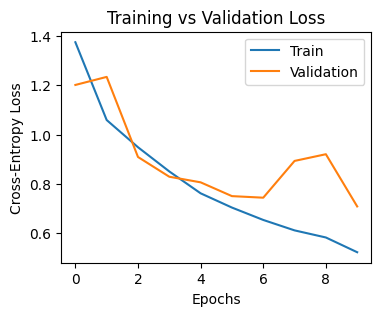

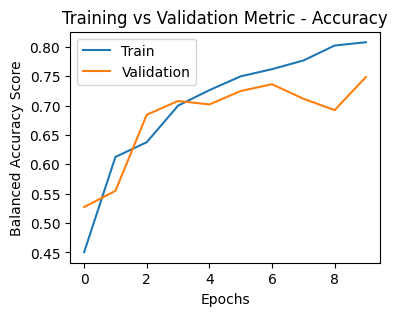

In [49]:
# train model on train and validation data
# create model
model = BaselineModel().to(device)

# define optimazer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define loss function
criterion = nn.CrossEntropyLoss().to(device)

# define number of epochs
num_epochs = 10

# train and evaluate model
train_losses,test_losses, train_accs, test_accs=train_model(model, criterion, optimizer,train_dataloader, val_dataloader, num_epochs)

# visualize the results
plot_loss_graph(train_losses,test_losses)
plot_accuracy_graph(train_accs,test_accs)

As we can see, the model works fine, and we can observe a significant decrease of the loss function and an increase in the accuracy for both train and validation data. We reached 75% accuracy and 74% f1_score  on the validation dataset, which is quite good results.

****************************************
Let's retrain our model on the concatenated train and valid datasets and evaluate on test data
****************************************

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/10], Loss: 0.5316, Acc: 0.8087287899255985, F1-score: 0.8016524123321888
Test epoch [1/10], Loss: 0.7186, Acc: 0.7384439153439154, , F1-score: 0.7466788026788027


0it [00:00, ?it/s]

Train epoch [2/10], Loss: 0.4748, Acc: 0.8303829179095138, F1-score: 0.8311003330662923
Test epoch [2/10], Loss: 0.7978, Acc: 0.7250455026455025, , F1-score: 0.7199550912050913


0it [00:00, ?it/s]

Train epoch [3/10], Loss: 0.4440, Acc: 0.8442510385595494, F1-score: 0.8392240502383801
Test epoch [3/10], Loss: 0.6730, Acc: 0.7775772486772486, , F1-score: 0.7629270510191563


0it [00:00, ?it/s]

Train epoch [4/10], Loss: 0.3841, Acc: 0.8762591338921123, F1-score: 0.8665343697837542
Test epoch [4/10], Loss: 0.7089, Acc: 0.7713481481481481, , F1-score: 0.7567661948617831


0it [00:00, ?it/s]

Train epoch [5/10], Loss: 0.3758, Acc: 0.8775983364547193, F1-score: 0.8738320165640207
Test epoch [5/10], Loss: 0.7784, Acc: 0.7383973544973543, , F1-score: 0.726582718207718


0it [00:00, ?it/s]

Train epoch [6/10], Loss: 0.3146, Acc: 0.8878938958992151, F1-score: 0.8855771044835412
Test epoch [6/10], Loss: 0.7386, Acc: 0.7463597883597883, , F1-score: 0.7352688561438561


0it [00:00, ?it/s]

Train epoch [7/10], Loss: 0.2894, Acc: 0.9003798171883278, F1-score: 0.8969323247471713
Test epoch [7/10], Loss: 0.7633, Acc: 0.7547042328042327, , F1-score: 0.7501109168609168


0it [00:00, ?it/s]

Train epoch [8/10], Loss: 0.2341, Acc: 0.9276438396119248, F1-score: 0.9258911700641906
Test epoch [8/10], Loss: 0.7570, Acc: 0.7463396825396825, , F1-score: 0.748284201909202


0it [00:00, ?it/s]

Train epoch [9/10], Loss: 0.2042, Acc: 0.9281156422379826, F1-score: 0.9270943864524375
Test epoch [9/10], Loss: 0.8560, Acc: 0.7397084656084656, , F1-score: 0.7394995976245975


0it [00:00, ?it/s]

Train epoch [10/10], Loss: 0.1859, Acc: 0.9379343843705545, F1-score: 0.9350258343456217
Test epoch [10/10], Loss: 0.8400, Acc: 0.7478925925925926, , F1-score: 0.7475244893994895


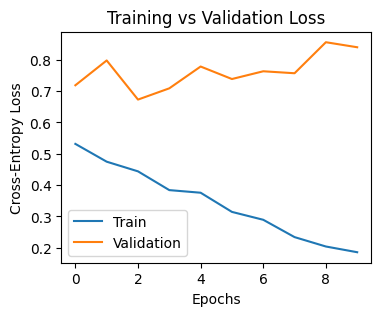

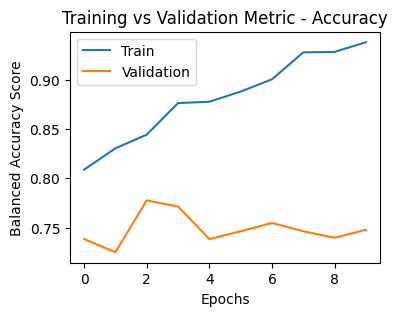

In [50]:
# let's concatenate train and val datasets and retrain model validating on test data
# Update the data loader for full training + validation dataset
train_val_dataset = ConcatDataset([train_dataset, val_dataset])
train_val_dataloader = DataLoader(train_val_dataset, batch_size=32, shuffle=True, num_workers=4)

# define optimizer with the best model parameters
optimizer_upd = torch.optim.Adam(model.parameters(), lr=0.001)

# retrain and reevaluate model
train_losses_upd,test_losses_upd, train_accs_upd, test_accs_upd=train_model(model, criterion, optimizer_upd,train_val_dataloader, test_dataloader, num_epochs)

# visualize the results
plot_loss_graph(train_losses_upd,test_losses_upd)
plot_accuracy_graph(train_accs_upd,test_accs_upd)

As we can see, the model works still good on training data, and we can observe a significant decrease of the loss function and increase of the accuracy one. But at the test data we have the same accuracy and f1_score that is approximately 75% and an unexpected rise of the loss function. It can signify that model is becoming overconfident (assigning probabilities that are too high for its predictions).The model could also be suffering from some degree of overfitting, where it fits well on the training data (and possibly validation), but struggles to generalize properly to unseen data (test).
 Let's try to get better results using transfer learning.

*********************************
Transfer learning
*********************************

In [24]:
# define train and validation transforms for images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [25]:
# create custom Dataset to get only certain number of images
class CustomSubsetDataset(Dataset):
    def __init__(self, dataset, num_samples_per_class):
        self.dataset = dataset
        self.num_samples_per_class = num_samples_per_class
        self.indices = self._get_subset_indices()

    def _get_subset_indices(self):
        # Get indices of images belonging to each class
        class_to_indices = {}
        for idx, class_idx in enumerate(self.dataset.targets):  # Only class_idx is used
            if class_idx not in class_to_indices:
                class_to_indices[class_idx] = []
            class_to_indices[class_idx].append(idx)

        # Randomly sample `num_samples_per_class` indices from each class
        sampled_indices = []
        for class_idx, indices in class_to_indices.items():
            sampled_indices.extend(random.sample(indices, min(self.num_samples_per_class, len(indices))))

        return sampled_indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx = self.indices[idx]
        return self.dataset[sample_idx]

In [26]:
sets = ['train', 'test']

# Create your datasets with a limited number of samples per class
image_datasets = {
    'train': CustomSubsetDataset(
        datasets.ImageFolder(os.path.join(data_path, 'seg_train'), data_transforms['train']),
        num_samples_per_class=300
    ),
    'test': CustomSubsetDataset(
        datasets.ImageFolder(os.path.join(data_path, 'seg_test'), data_transforms['test']),
        num_samples_per_class=100
    )
}

In [27]:
# create DataLoader class
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
  for x in sets}

In [28]:
# get information about dataset size and classes
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].dataset.classes

print(class_names)
print(dataset_sizes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'train': 1800, 'test': 600}


In [29]:
# create function to show image examples
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # Imagenet mean
    std = np.array([0.229, 0.224, 0.225]) # Imagenet std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

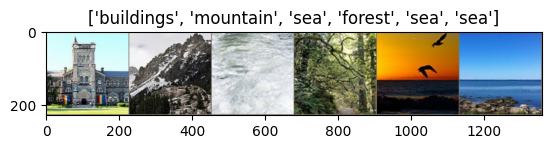

In [30]:
# visualize one batch
# get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# make a grid from batch
out = utils.make_grid(inputs[:6])

imshow(out, title=[class_names[x] for x in labels[:6]])

In [31]:
# define function of training model process
def train_model(model, criterion, optimizer, num_epochs=15):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

				# save model
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in sets:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [32]:
# function for results visualisation
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Learning of the whole model

In [33]:
# load pretrained weights of ResNet18 model
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# define final linear layer with number of output neurons equals to number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# pass all parameters into optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)

# train model
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


Epoch 1/15
----------
train Loss: 1.4170 Acc: 0.4789
test Loss: 0.9129 Acc: 0.6967

Epoch 2/15
----------
train Loss: 0.8412 Acc: 0.7467
test Loss: 0.5419 Acc: 0.8483

Epoch 3/15
----------
train Loss: 0.6215 Acc: 0.8039
test Loss: 0.4181 Acc: 0.8683

Epoch 4/15
----------
train Loss: 0.5152 Acc: 0.8472
test Loss: 0.3539 Acc: 0.8783

Epoch 5/15
----------
train Loss: 0.4669 Acc: 0.8444
test Loss: 0.3157 Acc: 0.8950

Epoch 6/15
----------
train Loss: 0.4319 Acc: 0.8567
test Loss: 0.2997 Acc: 0.8933

Epoch 7/15
----------
train Loss: 0.3950 Acc: 0.8661
test Loss: 0.2866 Acc: 0.9000

Epoch 8/15
----------
train Loss: 0.3615 Acc: 0.8822
test Loss: 0.2857 Acc: 0.9017

Epoch 9/15
----------
train Loss: 0.3490 Acc: 0.8856
test Loss: 0.2712 Acc: 0.9050

Epoch 10/15
----------
train Loss: 0.3296 Acc: 0.8944
test Loss: 0.2583 Acc: 0.9100

Epoch 11/15
----------
train Loss: 0.3124 Acc: 0.8928
test Loss: 0.2627 Acc: 0.9017

Epoch 12/15
----------
train Loss: 0.3103 Acc: 0.8961
test Loss: 0.2555 Ac

We can observe that transfer learning is very suitable for our case and gives us 91% accuracy on test data. Let's compare results with analogical model using frozen weights.

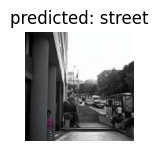

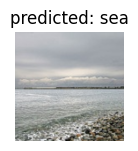

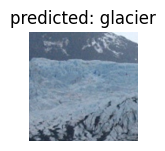

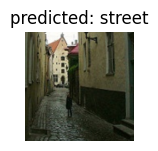

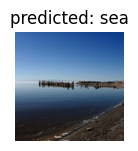

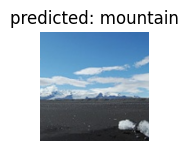

In [34]:
# visualize random model predictions
visualize_model(model_ft)

Learning with frozen weights

In [35]:
# train only classification layer
model_conv = models.resnet18(weights='IMAGENET1K_V1')

# switch off gradient calculation for all layers
for param in model_conv.parameters():
    param.requires_grad = False

# add classification layer, requires_grad = True is set by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# pass only parameters of only fully-connected layer
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-03)

# train the model
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.1350 Acc: 0.6089
test Loss: 0.6024 Acc: 0.8450

Epoch 2/15
----------
train Loss: 0.6509 Acc: 0.7811
test Loss: 0.4566 Acc: 0.8617

Epoch 3/15
----------
train Loss: 0.5455 Acc: 0.8211
test Loss: 0.3938 Acc: 0.8633

Epoch 4/15
----------
train Loss: 0.5129 Acc: 0.8239
test Loss: 0.3575 Acc: 0.8817

Epoch 5/15
----------
train Loss: 0.4702 Acc: 0.8222
test Loss: 0.3504 Acc: 0.8733

Epoch 6/15
----------
train Loss: 0.4651 Acc: 0.8278
test Loss: 0.3292 Acc: 0.8800

Epoch 7/15
----------
train Loss: 0.4611 Acc: 0.8306
test Loss: 0.3097 Acc: 0.8883

Epoch 8/15
----------
train Loss: 0.4258 Acc: 0.8439
test Loss: 0.2937 Acc: 0.8983

Epoch 9/15
----------
train Loss: 0.4249 Acc: 0.8478
test Loss: 0.3093 Acc: 0.8800

Epoch 10/15
----------
train Loss: 0.4167 Acc: 0.8400
test Loss: 0.3000 Acc: 0.8900

Epoch 11/15
----------
train Loss: 0.4067 Acc: 0.8511
test Loss: 0.2869 Acc: 0.8783

Epoch 12/15
----------
train Loss: 0.4273 Acc: 0.8478
test Loss: 0.2939 Ac

We see that transfer learning with frozen weights is much faster, that is obvious, but gives us a bit lower accuracy of 89% that is still very good result.

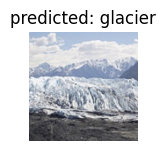

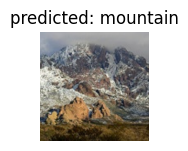

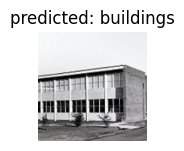

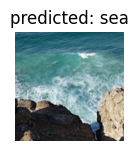

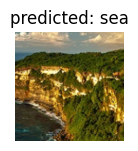

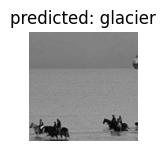

In [36]:
# visualize random prediction result
visualize_model(model_conv)

Finally we can conclude that transfer learning is the best choice in solving multiclass image classification problems. It gives us very good results from 88% to 91% accuracy depending on the chosen learning method. These high results are attributed to the fact that the pre-trained models already have strong features for image recognition that can be effectively adapted to a specific dataset, as in our case.